# Cybersecurity Readiness Index Project

## Project Overview
This project constructs a **Cybersecurity Readiness Index** to evaluate and compare how well-prepared different countries are in managing cybersecurity challenges. The index integrates multiple dimensions of cybersecurity capacity and readiness, and is designed as a tool to assist **policymakers, researchers, and institutions** in benchmarking and improving national cyber resilience.

## Index Dimensions
The index aggregates standardized indicators across key domains of cybersecurity capability:

1. **Technical Readiness**
   - Internet usage and digital infrastructure

2. **Policy and Legal Environment**
   - Number of cybercrime laws and regulatory frameworks

3. **Financial Exposure**
   - Average financial losses from cybercrime incidents

4. **AI and Governance Capacity**
   - Government AI Readiness (as a proxy for digital governance)

5. **Socioeconomic Context**
   - Tax revenue (% of GDP), urbanization, healthcare capacity, and unemployment rate

## Data Sources
The index draws on publicly available datasets including:
- World Bank (Internet usage, socioeconomic indicators)
- National Cybercrime Loss Reports (2020–2023)
- Global AI Readiness Index (Oxford Insights)
- Cybercrime Law Inventories
- Country Code Reference Data

## Methodology
1. **Data Preprocessing**
   - Cleaning, merging, and standardizing country-level datasets
   - ISO3 alignment for country matching

2. **Missing Data Handling**
   - Mean/median imputation where required

3. **Normalization**
   - Z-score standardization applied to all indicators

4. **Weighting**
   - Principal Component Analysis (PCA) applied to extract data-driven weights
   - Comparative analysis with equal weights and perturbed weights

5. **Composite Index Calculation**
   - Weighted aggregation of standardized indicators to produce an index score

6. **Validation & Sensitivity**
   - Rank comparison across different weighting methods
   - Correlation with AI Readiness Index and other global cybersecurity benchmarks:
     - CEI, GCI, NCSI, and DDL

7. **Visualization**
   - Correlation matrix and indicator distributions
   - Bar charts of top performers
   - Rank scatter comparisons
   - Interactive choropleth map of global scores

## Deliverables
- A final Cybersecurity Readiness Index with scores and ranks
- Comparative plots and visual insights
- AI correlation and benchmarking vs global indices
- Global choropleth visualisation using Plotly

## References
- Internet Usage Data -> internet_usage.csv (https://data.worldbank.org/indicator/IT.NET.USER.ZS)
- Global Net Crime Loss -> LossFromNetCrime.csv (https://www.kaggle.com/datasets/huzpsb/cybersecurity-incidents-dataset/data)
- Cybercrime laws per country -> cybercrime_laws.xlsx (https://www.data.gouv.fr/fr/datasets/protection-des-donnees-personnelles-dans-le-monde/)
- Global Cybersecurity Indexes -> Cyber_security.csv (https://www.kaggle.com/datasets/katerynameleshenko/cyber-security-indexes)
- Country Codes -> countrycodes.csv (https://www.kaggle.com/datasets/emolodov/country-codes-alpha2-alpha3)
- World Dataset -> world-data-2023.csv (https://databank.worldbank.org/)
- Domain expert + stakeholders -> (https://chatgpt.com/share/6818b095-9f5c-800b-80f7-7feef9805477)



## 📥 Data Loading
Load all relevant datasets including internet usage, cybercrime losses, and AI readiness.

In [92]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load each dataset with code that reflects standard notebook usage
internet_usage = pd.read_csv("Datasets/internet_usage.csv", skiprows=4)
net_crime_loss = pd.read_csv("Datasets/LossFromNetCrime.csv")
cybercrime_laws = pd.read_excel("Datasets/cybercrime_laws.xlsx")
country_codes = pd.read_csv("Datasets/countrycodes.csv")
ai_df = pd.read_excel("Datasets/2023_ai_readiness_index.xlsx")
world_df = pd.read_csv("Datasets/world-data-2023.csv")
cyber_indexes_df = pd.read_csv("Datasets/Cyber_security.csv")



# Display basic information to mimic typical Jupyter exploratory workflow
{
    "internet_usage": internet_usage.shape,
    "net_crime_loss": net_crime_loss.shape,
    "cybercrime_laws": cybercrime_laws.shape,
    "world_df": world_df.shape,
    "country_codes": country_codes.shape,
    "ai_df": ai_df.shape,
}

{'internet_usage': (266, 69),
 'net_crime_loss': (117, 13),
 'cybercrime_laws': (243, 3),
 'world_df': (195, 35),
 'country_codes': (249, 4),
 'ai_df': (193, 3)}

## 🧹 Data Cleaning & Preprocessing
Clean and align country data across all datasets using ISO3 codes.

In [93]:
# Reintegrate the updated missing value filtering logic into the full cleaning pipeline

# Step 0: Recreate avg_loss_merged in case it's undefined
loss_years = [col for col in net_crime_loss.columns if 'Losses' in col and '202' in col]
avg_loss_df = net_crime_loss[['Country'] + loss_years].copy()
avg_loss_df['Average_Loss'] = avg_loss_df[loss_years].mean(axis=1)
avg_loss_df = avg_loss_df[['Country', 'Average_Loss']].dropna().drop_duplicates(subset=['Country'])
avg_loss_merged = pd.merge(avg_loss_df, country_codes, left_on='Country', right_on='alpha2', how='left')
avg_loss_merged = avg_loss_merged[['country', 'Average_Loss']]
avg_loss_merged.columns = ['Country', 'Average_Loss']
avg_loss_merged = avg_loss_merged.drop_duplicates(subset=['Country'])

# Step 1: Clean and prepare each dataset using code patterns from example notebooks

# Get list of valid countries from reference list
valid_countries = country_codes['country'].unique().tolist()

# 1. Internet Usage (2023 only)
internet_usage_clean = internet_usage[['Country Name', 'Country Code', '2023']]
internet_usage_clean.columns = ['Country', 'ISO3', 'Internet_Usage_2023']
internet_usage_clean = internet_usage_clean.dropna().drop_duplicates(subset=['Country'])
internet_usage_clean = internet_usage_clean[internet_usage_clean['Country'].isin(valid_countries)]

# 2. Updated Cybercrime Loss (Average 2020–2023 with country name mapping)
net_crime_loss_clean = avg_loss_merged.copy()
net_crime_loss_clean = net_crime_loss_clean[net_crime_loss_clean['Country'].isin(valid_countries)]

# 3. Cybercrime Laws (count of laws)
cybercrime_laws_clean = cybercrime_laws[['Country']].dropna()
cybercrime_laws_clean = cybercrime_laws_clean.value_counts().reset_index(name='Cybercrime_Law_Count')
cybercrime_laws_clean = cybercrime_laws_clean[cybercrime_laws_clean['Country'].isin(valid_countries)]

# 6. Government AI Readiness (2023)
ai_clean = ai_df[['Country', 'Total']].copy()
ai_clean.columns = ['Country', 'AI_Readiness_2023']
ai_clean = ai_clean.dropna().drop_duplicates(subset=['Country'])
ai_clean = ai_clean[ai_clean['Country'].isin(valid_countries)]

# 7. World Data 2023 (selected indicators)
selected_columns = {
    'Country': 'Country',
    'Urban_population': 'Urban_population',
    'Unemployment rate': 'Unemployment_Rate',
    'Physicians per thousand': 'Physicians_per_Thousand',
    'Tax revenue (%)': 'Tax_Revenue_Percent'
}
world_data_clean = world_df[list(selected_columns.keys())].rename(columns=selected_columns)

for col in ['Unemployment_Rate', 'Tax_Revenue_Percent']:
    world_data_clean[col] = world_data_clean[col].str.replace('%', '', regex=False).astype(float)

world_data_clean['Physicians_per_Thousand'] = pd.to_numeric(world_data_clean['Physicians_per_Thousand'], errors='coerce')
world_data_clean['Urban_population'] = world_data_clean['Urban_population'].str.replace(',', '')
world_data_clean['Urban_population'] = pd.to_numeric(world_data_clean['Urban_population'], errors='coerce')
world_data_clean = world_data_clean.drop_duplicates(subset=['Country'])
world_data_clean = world_data_clean.dropna(thresh=2)
world_data_clean = world_data_clean[world_data_clean['Country'].isin(valid_countries)]

# Final merge pipeline
merged_df = pd.merge(internet_usage_clean, net_crime_loss_clean, on='Country', how='outer')
merged_df = pd.merge(merged_df, cybercrime_laws_clean, on='Country', how='left')
merged_df = pd.merge(merged_df, ai_clean, on='Country', how='left')
merged_df = pd.merge(merged_df, world_data_clean, on='Country', how='left')

# Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['Country'])

# Step 2: Identify index-ready countries vs. "Unknown" based on missing indicators
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status']
indicator_columns = [col for col in merged_df.columns if col not in non_indicator_columns]

# Recalculate missing counts using only indicator columns
merged_df['Missing_Count'] = merged_df[indicator_columns].isnull().sum(axis=1)

# Separate index-ready and unknown countries
unknown_countries_df = merged_df[merged_df['Missing_Count'] >= 3].copy()
index_ready_df = merged_df[merged_df['Missing_Count'] < 3].copy()
unknown_countries_df['Index_Status'] = 'Unknown'

# Show final counts
index_ready_df.shape[0], unknown_countries_df.shape[0]

# Display the final ready index dataset
index_ready_df.head()


,Country,ISO3,Internet_Usage_2023,Average_Loss,Cybercrime_Law_Count,AI_Readiness_2023,Urban_population,Unemployment_Rate,Physicians_per_Thousand,Tax_Revenue_Percent,Missing_Count
0,Afghanistan,AFG,17.7,27711078.2,1.0,21.268713,9797273.0,11.12,0.28,9.3,0
1,Albania,ALB,83.1,36298044.4,1.0,43.262394,1747593.0,12.33,1.20,18.6,0
2,Algeria,DZA,76.9,NaN,1.0,35.988109,31510100.0,11.70,1.72,37.2,1
4,Angola,AGO,44.8,12097971.8,2.0,29.140256,21061025.0,6.89,0.21,9.2,0
5,Antigua and Barbuda,ATG,77.6,NaN,2.0,39.410805,23800.0,NaN,2.76,16.5,2


## 🔧 Handling Missing Values
Apply imputation strategies to deal with missing indicator values.

In [94]:
# Impute missing values in index_ready_df using the specified logic

# 1. Median imputation
index_ready_df['Average_Loss'] = index_ready_df['Average_Loss'].fillna(index_ready_df['Average_Loss'].median())
index_ready_df['Cybercrime_Law_Count'] = index_ready_df['Cybercrime_Law_Count'].fillna(index_ready_df['Cybercrime_Law_Count'].median())

# 2. Mean imputation
index_ready_df['Tax_Revenue_Percent'] = index_ready_df['Tax_Revenue_Percent'].fillna(index_ready_df['Tax_Revenue_Percent'].mean())
index_ready_df['Internet_Usage_2023'] = index_ready_df['Internet_Usage_2023'].fillna(index_ready_df['Internet_Usage_2023'].mean())
index_ready_df['Unemployment_Rate'] = index_ready_df['Unemployment_Rate'].fillna(index_ready_df['Unemployment_Rate'].mean())
index_ready_df['AI_Readiness_2023'] = index_ready_df['AI_Readiness_2023'].fillna(index_ready_df['AI_Readiness_2023'].mean())

# Confirm that no missing values remain in the indicators
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]

# Check for any remaining missing values
index_ready_df[indicator_columns].isnull().sum()

# Display the final imputed index dataset
index_ready_df.head()


,Country,ISO3,Internet_Usage_2023,Average_Loss,Cybercrime_Law_Count,AI_Readiness_2023,Urban_population,Unemployment_Rate,Physicians_per_Thousand,Tax_Revenue_Percent,Missing_Count
0,Afghanistan,AFG,17.7,27711078.2,1.0,21.268713,9797273.0,11.120000,0.28,9.3,0
1,Albania,ALB,83.1,36298044.4,1.0,43.262394,1747593.0,12.330000,1.20,18.6,0
2,Algeria,DZA,76.9,118925433.6,1.0,35.988109,31510100.0,11.700000,1.72,37.2,1
4,Angola,AGO,44.8,12097971.8,2.0,29.140256,21061025.0,6.890000,0.21,9.2,0
5,Antigua and Barbuda,ATG,77.6,118925433.6,2.0,39.410805,23800.0,6.675918,2.76,16.5,2


## ⚖️ Normalization
Standardize indicators using z-score normalization (mean = 0, std = 1).

In [95]:
# Standardise the indicator columns using z-score (mean = 0, std = 1), following the Composite Index Handbook

# Identify only the indicator columns
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]

# Initialise the scaler and fit-transform the data
scaler = StandardScaler()
standardised_values = scaler.fit_transform(index_ready_df[indicator_columns])

# Convert to DataFrame and merge with metadata
standardised_df = pd.DataFrame(standardised_values, columns=[f"z_{col}" for col in indicator_columns])
standardised_df = pd.concat([index_ready_df[['Country', 'ISO3']], standardised_df], axis=1)

# Return preview of standardised data
standardised_df.head()


,Country,ISO3,z_Internet_Usage_2023,z_Average_Loss,z_Cybercrime_Law_Count,z_AI_Readiness_2023,z_Urban_population,z_Unemployment_Rate,z_Physicians_per_Thousand,z_Tax_Revenue_Percent
0,Afghanistan,AFG,-2.343128,-0.380756,-0.574089,-1.667909,-0.197743,9.109476e-01,-1.036854,-1.106620
1,Albania,ALB,0.410653,-0.374103,-0.574089,-0.253318,-0.294475,1.158973e+00,-0.483351,0.268877
2,Algeria,DZA,0.149591,-0.310089,-0.574089,-0.721186,0.063178,1.029836e+00,-0.170502,3.019873
4,Angola,AGO,0.179066,-0.310089,0.798343,-0.501045,-0.315190,-1.820588e-16,0.455197,-0.041719
5,Antigua and Barbuda,ATG,0.667504,-0.165171,4.915638,0.676835,0.181297,6.383242e-01,1.177156,-0.988298


## 🔗 Indicator Correlation
Visualize correlations between indicators to understand multicollinearity.

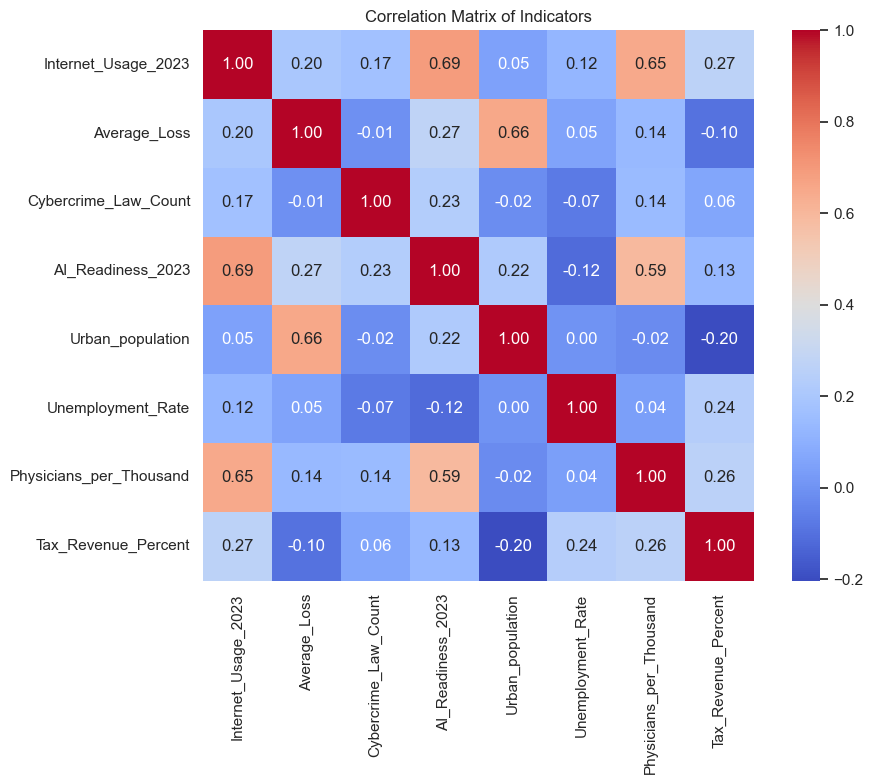

In [96]:
# Step 1: Correlation analysis using original (non-standardised) indicator values
# Extract indicator columns from the imputed index-ready dataset
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]
indicator_data = index_ready_df[indicator_columns]

# Compute correlation matrix
correlation_matrix = indicator_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Indicators")
plt.tight_layout()
plt.show()

## 📊 PCA for Weighting
Apply PCA to extract weights for index construction based on explained variance.

In [97]:
# Step 1: Select only indicator columns
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status', 'Cybersecurity_Readiness_Index', 'Rank']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]
X = index_ready_df[indicator_columns]

# Step 1.1: Show a list of the indicators
print("Indicators used in the analysis:")
for i, indicator in enumerate(indicator_columns, 1):
    print(f"{i}. {indicator}")


# Step 2: Standardise the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Step 3: Fit PCA
pca = PCA()
pca.fit(X_std)

# Step 4: Retrieve explained variance ratios (weights) and factor loadings
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(indicator_columns))],
    index=indicator_columns
).round(3)

explained_variance_ratio.round(3)



Indicators used in the analysis:
1. Internet_Usage_2023
2. Average_Loss
3. Cybercrime_Law_Count
4. AI_Readiness_2023
5. Urban_population
6. Unemployment_Rate
7. Physicians_per_Thousand
8. Tax_Revenue_Percent


array([0.321, 0.215, 0.151, 0.111, 0.082, 0.049, 0.04 , 0.03 ])

## 🧮 Scree Plot & Component Selection
Plot explained variance and apply selection criteria (eigenvalues > 1, ≥60% variance).

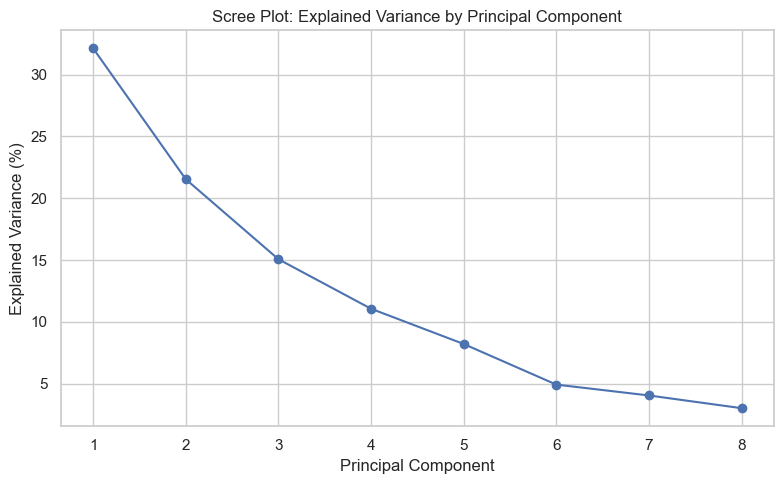

{'Components retained (Kaiser Criterion)': 3,
 'Components retained (Cumulative Variance ≥ 60%)': 3,
 'Cumulative Variance (%) by PC': [32.12,
  53.66,
  68.73,
  79.79,
  88.0,
  92.93,
  96.98,
  100.0]}

In [98]:
# Generate Scree Plot from PCA explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)


plt.figure(figsize=(8, 5))
plt.plot(range(1, num_components + 1), explained_variance_ratio * 100, marker='o', linestyle='-')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, num_components + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Implement retention logic based on two criteria:
# 1. Kaiser Criterion (eigenvalues > 1)
# 2. Cumulative variance >= 60%

# Calculate eigenvalues
eigenvalues = pca.explained_variance_

# 1. Kaiser Criterion: PCs with eigenvalue > 1
kaiser_components = np.sum(eigenvalues > 1)

# 2. Cumulative Variance Explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components_for_60_percent = np.argmax(cumulative_variance >= 0.60) + 1  # +1 for index to count

# Return both results
{
    "Components retained (Kaiser Criterion)": kaiser_components,
    "Components retained (Cumulative Variance ≥ 60%)": components_for_60_percent,
    "Cumulative Variance (%) by PC": np.round(cumulative_variance * 100, 2).tolist()
}


## 📦 Outlier Detection
Use boxplots to identify and visualize potential outliers in the indicators.

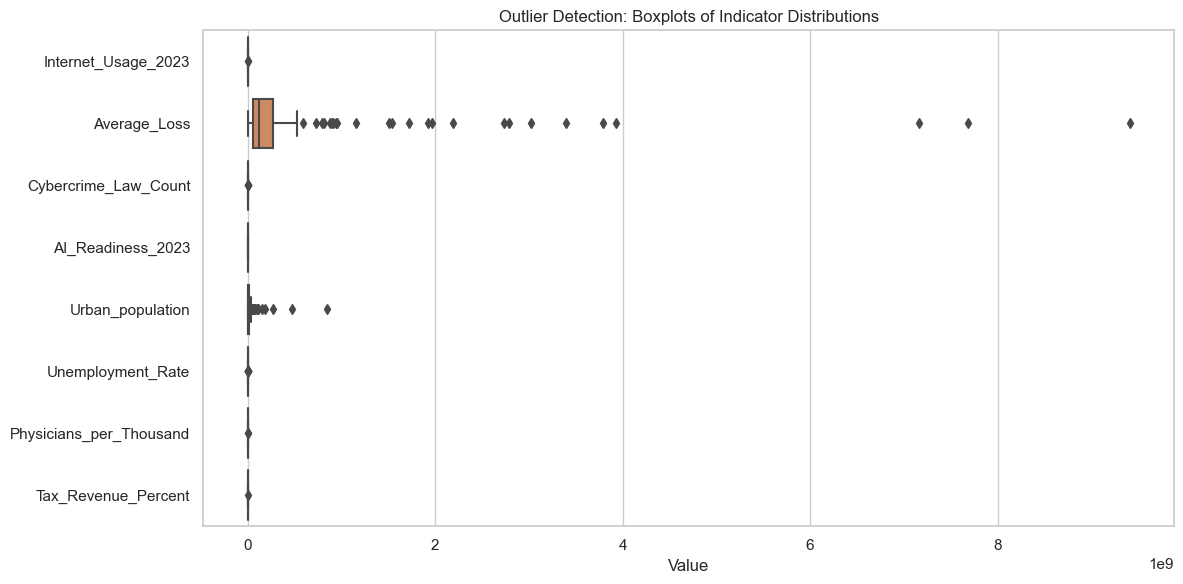

In [99]:
# Step: Outlier Detection
# We'll use boxplots to inspect each original indicator for potential outliers

# Extract indicators from index_ready_df
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status', 'Cybersecurity_Readiness_Index', 'Rank']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]

# Set up boxplots for all indicators
plt.figure(figsize=(12, 6))
sns.boxplot(data=index_ready_df[indicator_columns], orient='h')
plt.title('Outlier Detection: Boxplots of Indicator Distributions')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

## 🧾 Composite Index Calculation
Compute the final Cybersecurity Readiness Index using PCA-based weights.

In [100]:
# Identify indicator columns again, excluding non-indicator metadata
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(index_ready_df[indicator_columns])

# Compute the index: dot product of indicators and PCA-derived weights
index_scores = np.dot(X_std, explained_variance_ratio)

# Save the index and ranking
index_ready_df['Cybersecurity_Readiness_Index'] = index_scores
index_ready_df['Rank'] = index_ready_df['Cybersecurity_Readiness_Index'].rank(ascending=False).astype(int)

# Preview the results
index_ready_df[['Country', 'Cybersecurity_Readiness_Index', 'Rank']].sort_values(by='Rank').head(10)

,Country,Cybersecurity_Readiness_Index,Rank
33,China,1.996283,1
167,United States,1.969190,2
130,Russia,1.448960,3
22,Brazil,1.169558,4
57,Germany,1.156984,5
111,Netherlands,1.141474,6
6,Argentina,1.058625,7
54,France,0.987039,8
112,New Zealand,0.902625,9
32,Chile,0.871682,10


## 🔁 Sensitivity Analysis
Compare index results using PCA weights, perturbed weights, and equal weighting.

In [101]:
# Identify indicator columns again
non_indicator_columns = ['Country', 'ISO3', 'Missing_Count', 'Index_Status', 'Cybersecurity_Readiness_Index', 'Rank']
indicator_columns = [col for col in index_ready_df.columns if col not in non_indicator_columns]

# Standardize the indicator data
scaler = StandardScaler()
X_std = scaler.fit_transform(index_ready_df[indicator_columns])

# === 1. Original PCA weights ===
index_ready_df['Index_PCA'] = np.dot(X_std, explained_variance_ratio)

# === 2. Slightly perturbed PCA weights (add 10% Gaussian noise) ===
np.random.seed(0)
perturbed_weights = explained_variance_ratio + np.random.normal(0, 0.1 * explained_variance_ratio, size=explained_variance_ratio.shape)
perturbed_weights = perturbed_weights / perturbed_weights.sum()
index_ready_df['Index_PCA_Perturbed'] = np.dot(X_std, perturbed_weights)

# === 3. Equal weights ===
equal_weights = np.ones_like(explained_variance_ratio) / len(explained_variance_ratio)
index_ready_df['Index_Equal'] = np.dot(X_std, equal_weights)

# === Rank Comparisons ===
index_ready_df['Rank_PCA'] = index_ready_df['Index_PCA'].rank(ascending=False).astype(int)
index_ready_df['Rank_PCA_Perturbed'] = index_ready_df['Index_PCA_Perturbed'].rank(ascending=False).astype(int)
index_ready_df['Rank_Equal'] = index_ready_df['Index_Equal'].rank(ascending=False).astype(int)

# === Sensitivity Output Table ===
index_ready_df[['Country', 'Rank_PCA', 'Rank_PCA_Perturbed', 'Rank_Equal']].sort_values(by='Rank_PCA').head(10)

,Country,Rank_PCA,Rank_PCA_Perturbed,Rank_Equal
33,China,1,1,1
167,United States,2,2,2
130,Russia,3,3,8
22,Brazil,4,4,3
57,Germany,5,5,9
111,Netherlands,6,6,5
6,Argentina,7,7,6
54,France,8,8,4
112,New Zealand,9,9,7
32,Chile,10,10,14


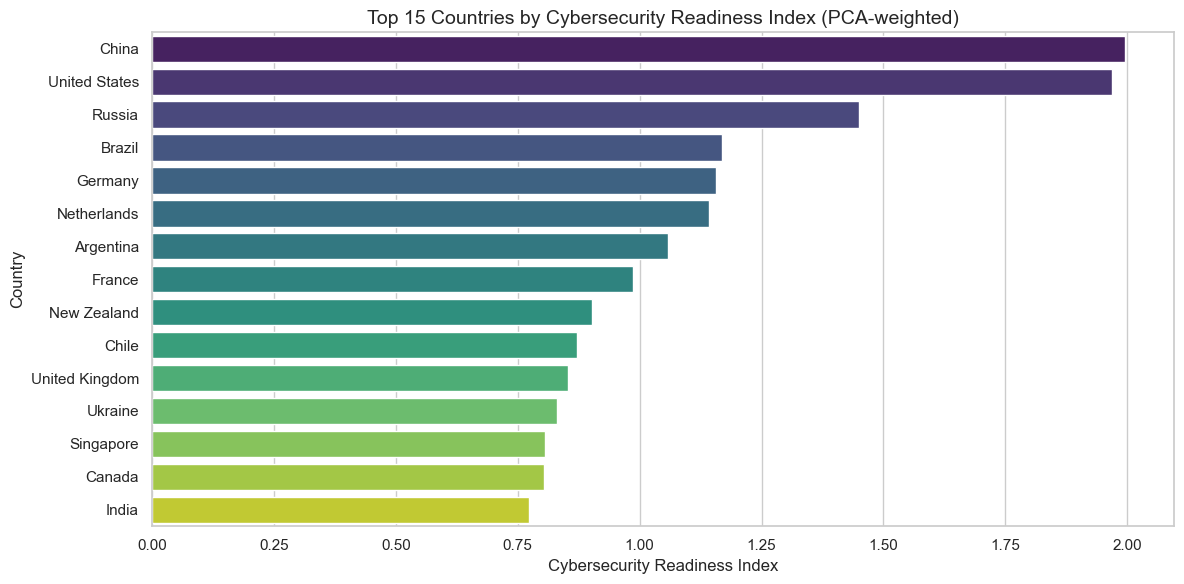

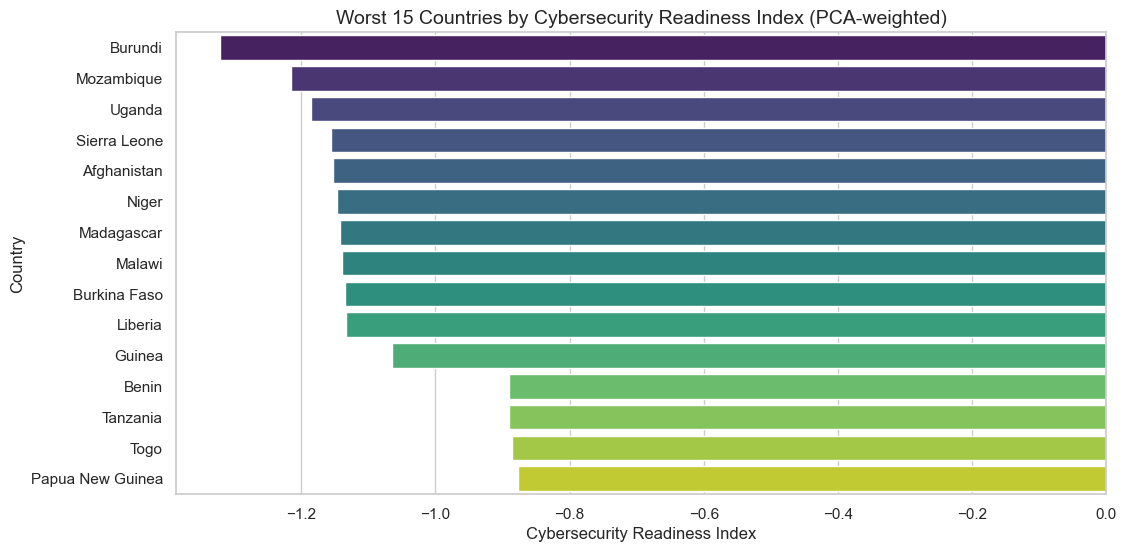

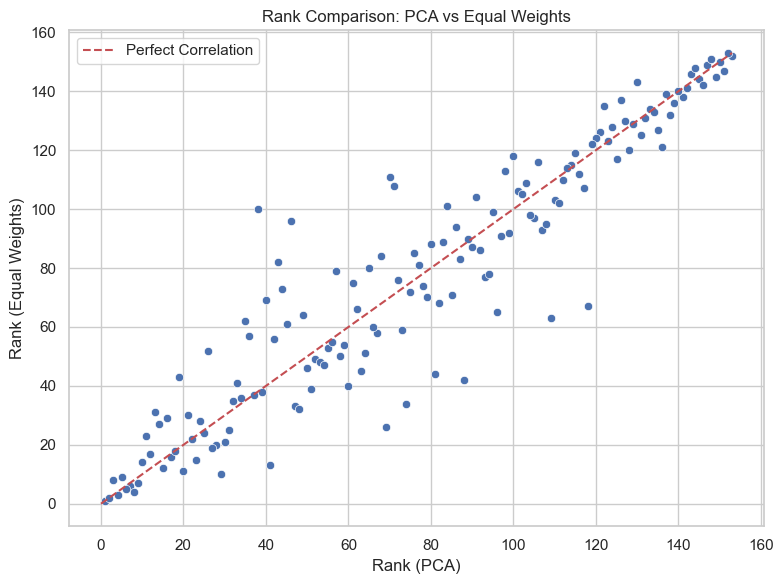

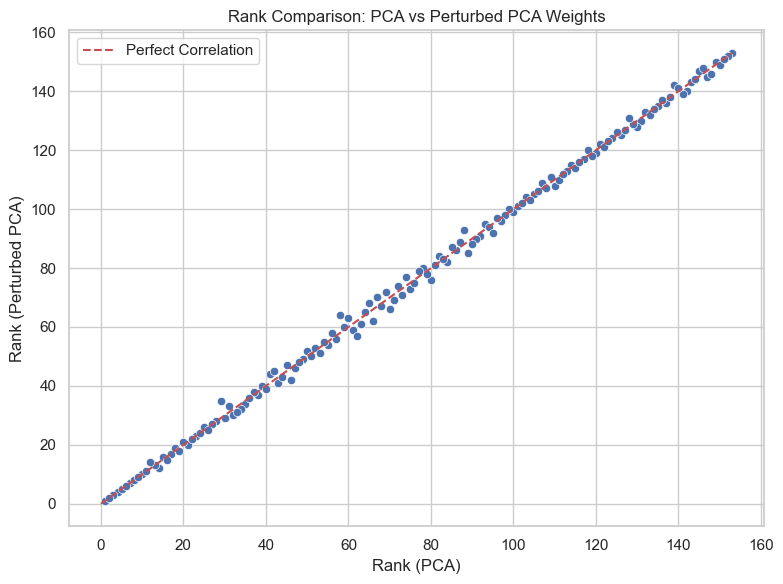

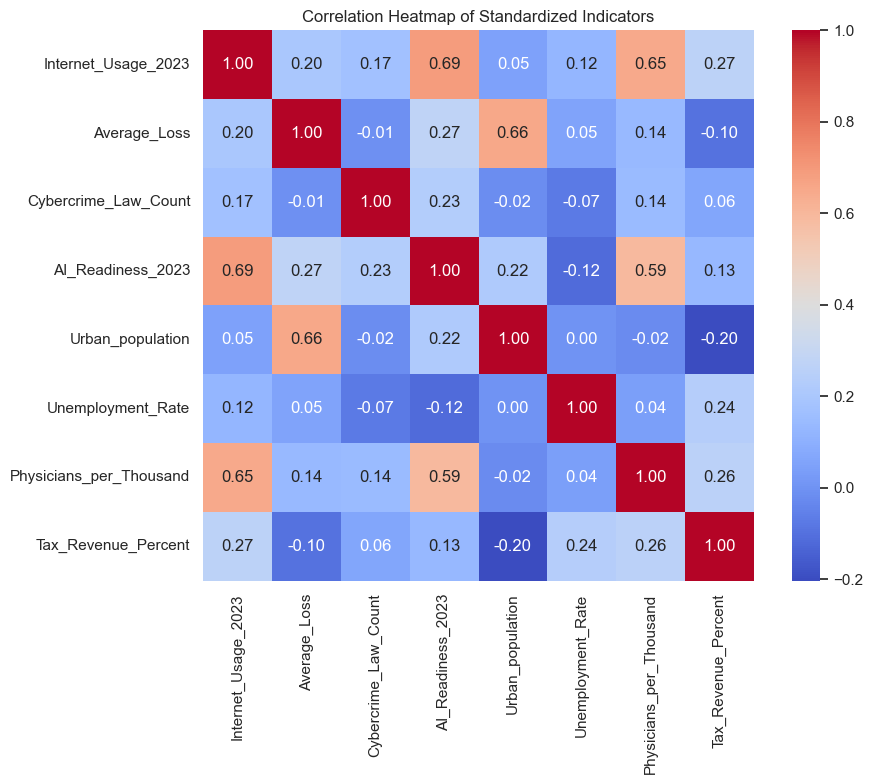

In [102]:
# Set style
sns.set_theme(style="whitegrid")

# === 1. Top 15 Countries by Cybersecurity Readiness Index (PCA) ===
top_15 = index_ready_df.sort_values(by='Index_PCA', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_15, x='Index_PCA', y='Country', palette='viridis')
plt.title("Top 15 Countries by Cybersecurity Readiness Index (PCA-weighted)", fontsize=14)
plt.xlabel("Cybersecurity Readiness Index")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# === 1.1 Worst 15 Countries by Cybersecurity Readiness Index (PCA) ===
bottom_15 = index_ready_df.sort_values(by='Index_PCA', ascending=True).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_15, x='Index_PCA', y='Country', palette='viridis')
plt.title("Worst 15 Countries by Cybersecurity Readiness Index (PCA-weighted)", fontsize=14)
plt.xlabel("Cybersecurity Readiness Index")
plt.ylabel("Country")

# === 2. Rank Comparison: PCA vs Equal Weights ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=index_ready_df, x='Rank_PCA', y='Rank_Equal')
plt.plot([0, index_ready_df['Rank_PCA'].max()], [0, index_ready_df['Rank_PCA'].max()], 'r--', label='Perfect Correlation')
plt.title("Rank Comparison: PCA vs Equal Weights")
plt.xlabel("Rank (PCA)")
plt.ylabel("Rank (Equal Weights)")
plt.legend()
plt.tight_layout()
plt.show()

# === 3. Rank Comparison: PCA vs Perturbed PCA Weights ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=index_ready_df, x='Rank_PCA', y='Rank_PCA_Perturbed')
plt.plot([0, index_ready_df['Rank_PCA'].max()], [0, index_ready_df['Rank_PCA'].max()], 'r--', label='Perfect Correlation')
plt.title("Rank Comparison: PCA vs Perturbed PCA Weights")
plt.xlabel("Rank (PCA)")
plt.ylabel("Rank (Perturbed PCA)")
plt.legend()
plt.tight_layout()
plt.show()


# === 4. Correlation Heatmap of Indicator Variables ===
plt.figure(figsize=(10, 8))
corr_matrix = index_ready_df[indicator_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Standardized Indicators")
plt.tight_layout()
plt.show()


## 📉 Rank Comparison Visualizations
Scatter plots comparing country ranks under different weighting methods.

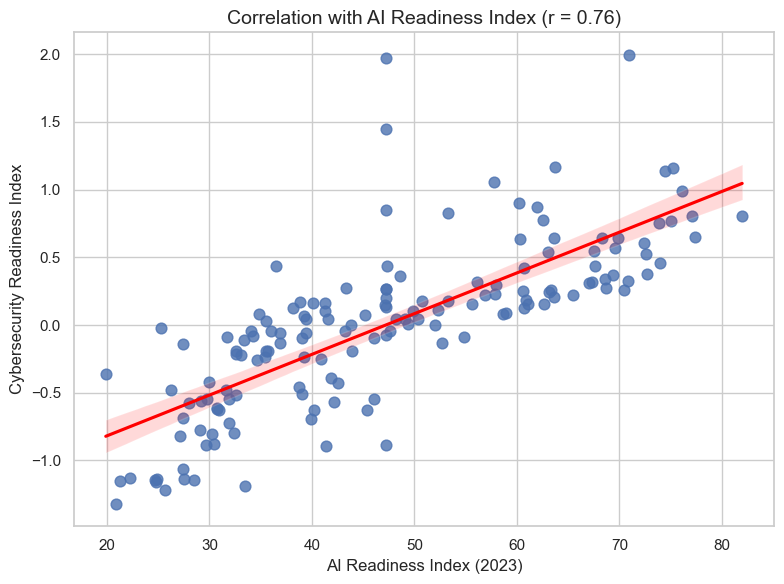

In [103]:
# Drop rows with missing AI or Cybersecurity index
correlation_df = index_ready_df[['Country', 'AI_Readiness_2023', 'Cybersecurity_Readiness_Index']].dropna()

# Calculate Pearson correlation coefficient
correlation_value = correlation_df['AI_Readiness_2023'].corr(correlation_df['Cybersecurity_Readiness_Index'])

# Plot correlation
plt.figure(figsize=(8, 6))
sns.regplot(data=correlation_df,
            x='AI_Readiness_2023',
            y='Cybersecurity_Readiness_Index',
            scatter_kws={'s': 60},
            line_kws={'color': 'red'})
plt.title(f"Correlation with AI Readiness Index (r = {correlation_value:.2f})", fontsize=14)
plt.xlabel("AI Readiness Index (2023)")
plt.ylabel("Cybersecurity Readiness Index")
plt.tight_layout()
plt.show()


## 🌍 External Index Correlation
Compare your index with CEI, GCI, NCSI, and DDL indices.

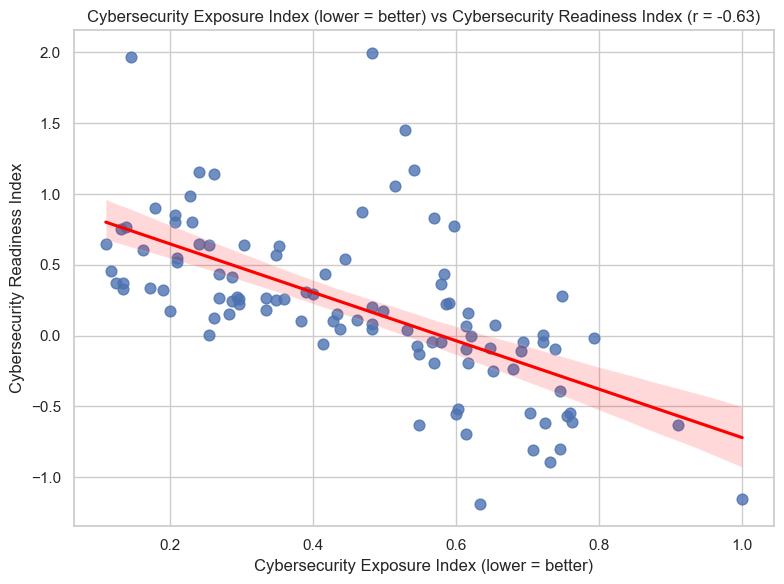

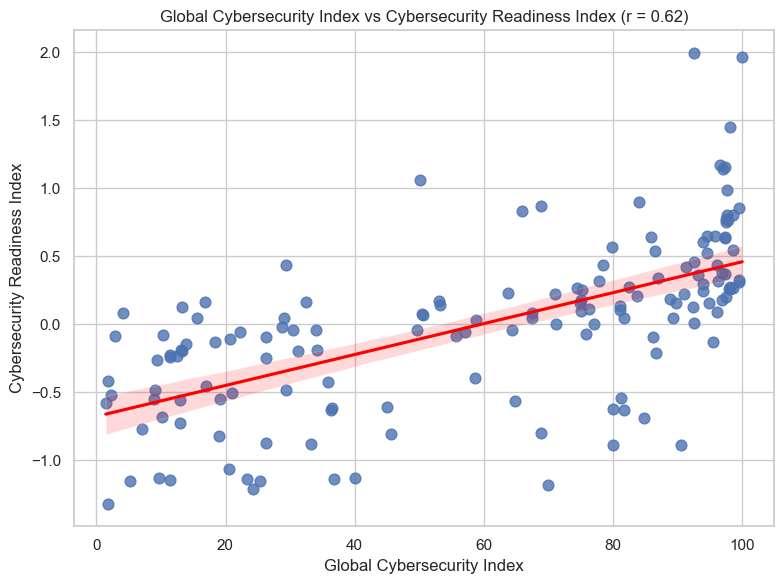

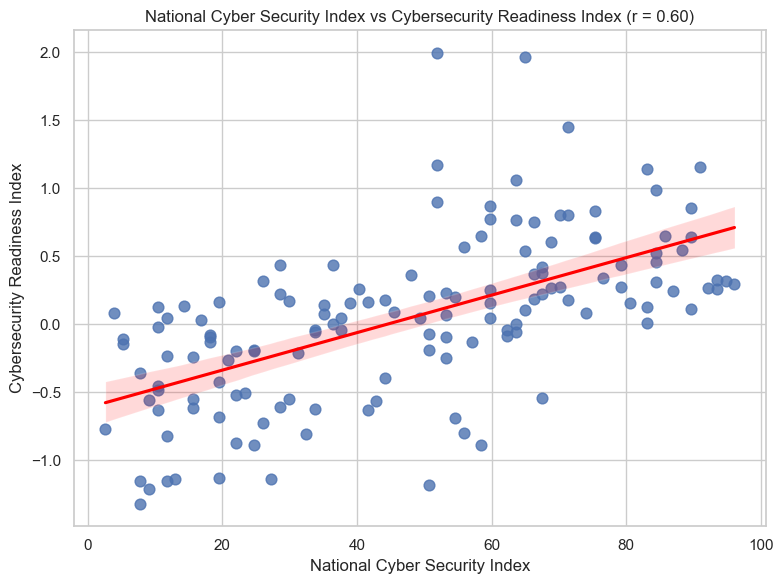

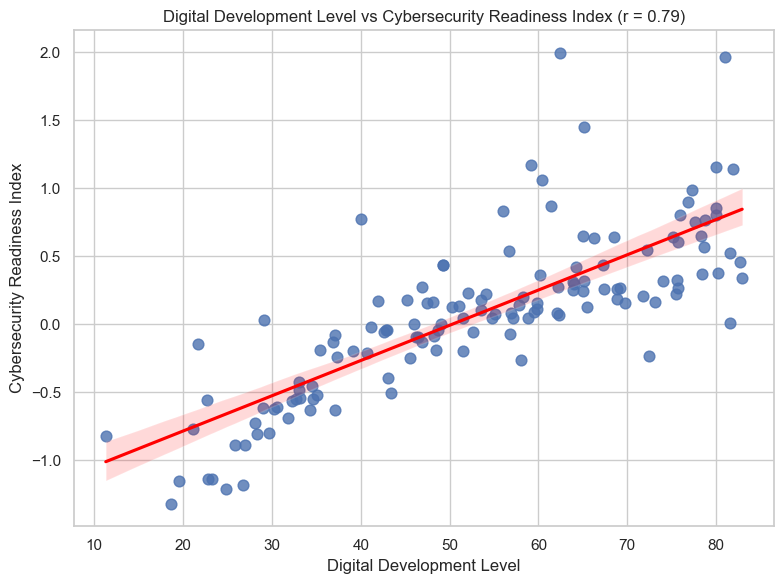

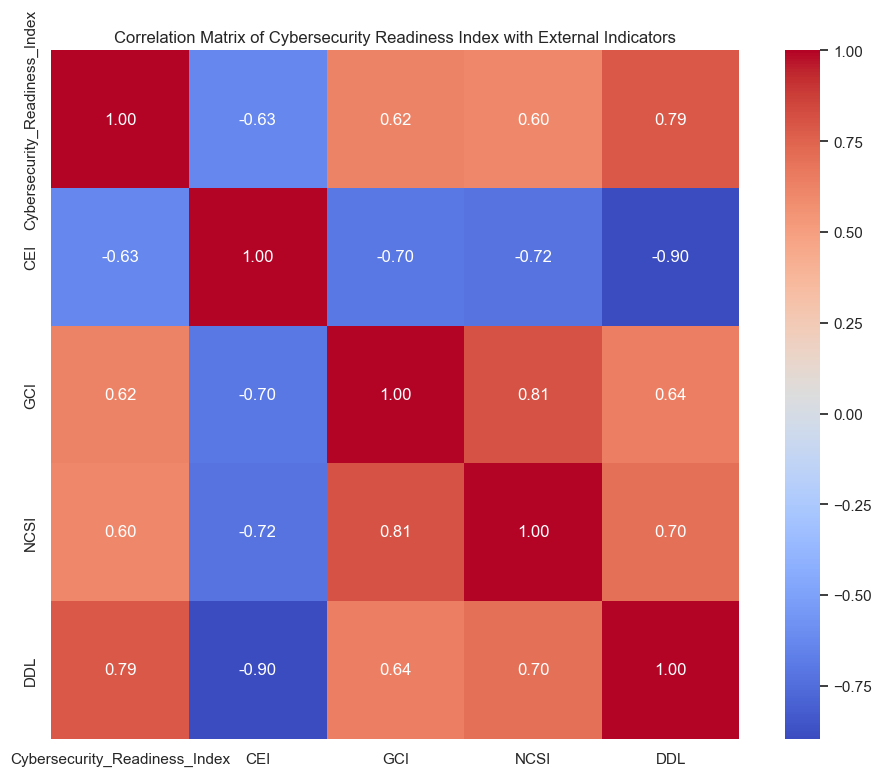

In [104]:
# Load external comparison file (if not already loaded)


# Merge your index with external indices
cyber_indexes_df['Country'] = cyber_indexes_df['Country'].str.strip()
merged_df = pd.merge(index_ready_df, cyber_indexes_df, on='Country', how='inner')

# List of external cybersecurity indicators
external_cols = ['CEI', 'GCI', 'NCSI', 'DDL']
correlations = {}

# Compute Pearson correlation for each
for col in external_cols:
    sub = merged_df[['Cybersecurity_Readiness_Index', col]].dropna()
    correlations[col] = sub['Cybersecurity_Readiness_Index'].corr(sub[col])

# Show results
pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Your Index'])

# Define external columns and titles
external_columns = {
    'CEI': 'Cybersecurity Exposure Index (lower = better)',
    'GCI': 'Global Cybersecurity Index',
    'NCSI': 'National Cyber Security Index',
    'DDL': 'Digital Development Level'
}

# Plot scatter comparisons with trendlines
for col, title in external_columns.items():
    sub_df = merged_df[['Cybersecurity_Readiness_Index', col]].dropna()

    if not sub_df.empty:
        correlation = sub_df['Cybersecurity_Readiness_Index'].corr(sub_df[col])
        
        plt.figure(figsize=(8, 6))
        sns.regplot(data=sub_df, x=col, y='Cybersecurity_Readiness_Index',
                    scatter_kws={'s': 60}, line_kws={'color': 'red'})
        plt.title(f"{title} vs Cybersecurity Readiness Index (r = {correlation:.2f})")
        plt.xlabel(title)
        plt.ylabel("Cybersecurity Readiness Index")
        plt.tight_layout()
        plt.show()
        
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df[['Cybersecurity_Readiness_Index', 'CEI', 'GCI', 'NCSI', 'DDL']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Cybersecurity Readiness Index with External Indicators")
plt.tight_layout()
plt.show()


## 🗺️ Global Map Visualization
Visualize the composite index using a world choropleth map (Plotly).

In [105]:
import plotly.express as px

fig = px.choropleth(
    index_ready_df,
    locations="ISO3",
    color="Cybersecurity_Readiness_Index",
    hover_name="Country",
    color_continuous_scale="BuGn",
    title="Global Cybersecurity Readiness Index"
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()